# Masked Deblending in the Rubin Active Optics System Wavefront Estimation Pipeline

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach)) <br>
Last Verified to Run: 2024-06-07 <br>
Software Versions:
  - `ts_wep`: **v9.5.4**
  - `ts_imsim`: **v1.5.2**
  - `lsst_distrib`: **w_2024_22**

## Notebook Objective:

In this notebook we will introduce the masked fitting deblender in `ts_wep` and analyze the range of validity of its application.

## Logistics

This notebook is meant to be run on the Rubin USDF notebook portal: https://usdf-rsp.slac.stanford.edu/.

## Imports

In [1]:
import os
import yaml
from lsst.daf.butler import Butler
from lsst.afw import image as afwImage

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["image.origin"] = 'lower'

from scipy.ndimage import rotate, shift, binary_dilation
from lsst.ts.wep.task import GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig
from lsst.ts.wep.task import CalcZernikesTask, CalcZernikesTaskConfig
from lsst.ts.wep.utils import convertMetadataToHistory
%matplotlib inline

## Data

A set of data with overlapping donuts on the extra-focal detectors of the corner wavefront detectors (CWFS) of LSSTCam has been saved on the USDF for running this notebook and for testing of deblending algorithms. The data was simulated with two donuts of the same g=14.5 magnitude separated by only 110 pixels (the radius of each donut on the CWFS is 126 pixels) on the extra-focal detectors. The intra-focal detectors each contain a single donut also of magnitude g=14.5 pixels located in the center of the detector. The repo with this data is found at: 
```bash
/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/donut_deblending/donut_deblending_tests/
```

In [2]:
# Load initial data locations on USDF
notebook_data = '/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/donut_deblending'
butler_repo = os.path.join(notebook_data, 'deblend_test_repo')

In [3]:
# Create butler
butler = Butler(butler_repo)

In [4]:
# Set initial data IDs for a pair of corner sensors
dataIdExtra = {
    'instrument': 'LSSTCam', 
    'detector': 191, 
    'exposure': 7023062001000,
    'visit': 7023062001000
}
dataIdIntra = {
    'instrument': 'LSSTCam', 
    'detector': 192, 
    'exposure': 7023062001000,
    'visit': 7023062001000
}

# Load postISR images and camera object
postIsrExtra = butler.get('postISRCCD', dataId=dataIdExtra, collections='cwfs_extrafocal_110_pixels_separation')
postIsrIntra = butler.get('postISRCCD', dataId=dataIdIntra, collections='cwfs_extrafocal_110_pixels_separation')
camera = butler.get('camera', instrument='LSSTCam', collections='LSSTCam/calib/unbounded')

Text(0.5, 1.0, 'Blended Extra-focal donuts (110 px Separation)')

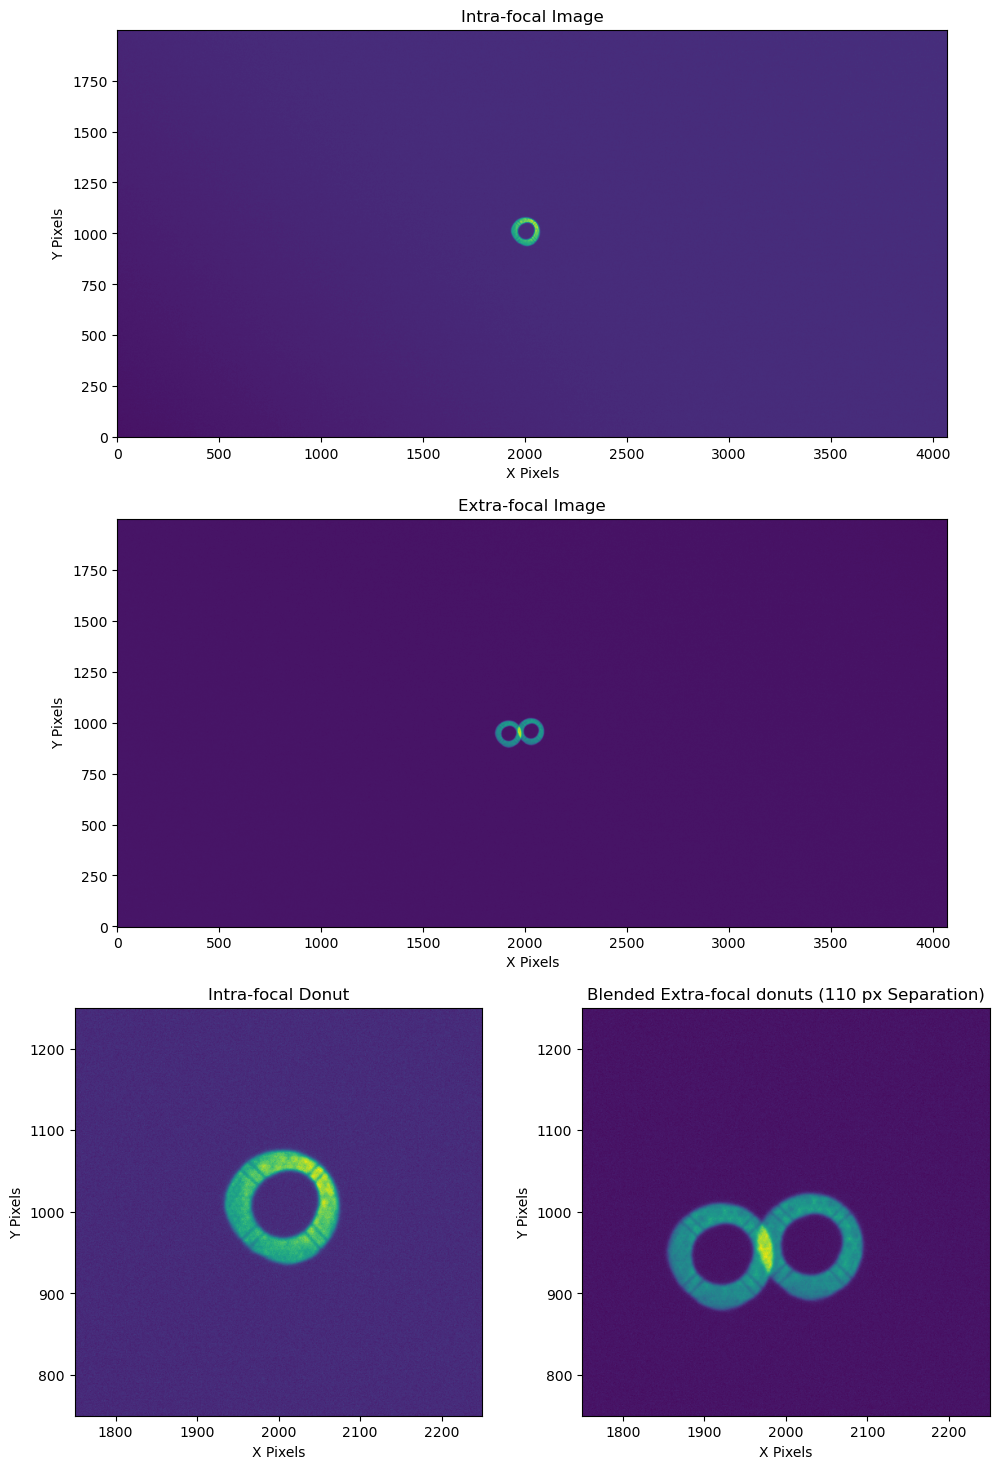

In [5]:
fig = plt.figure(figsize=(12, 18))

fig.add_subplot(3,1,1)
plt.imshow(postIsrIntra.image.array, origin='lower')
plt.ylabel('Y Pixels')
plt.xlabel('X Pixels')
plt.title('Intra-focal Image')

fig.add_subplot(3,1,2)
plt.imshow(postIsrExtra.image.array, origin='lower')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Extra-focal Image')

fig.add_subplot(3,2,5)
plt.imshow(postIsrIntra.image.array, origin='lower')
plt.xlim(1750, 2250)
plt.ylim(750, 1250)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Intra-focal Donut')

fig.add_subplot(3,2,6)
plt.imshow(postIsrExtra.image.array, origin='lower')
plt.xlim(1750, 2250)
plt.ylim(750, 1250)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Blended Extra-focal donuts (110 px Separation)')

**Figure 1**: Top, Middle: Post ISR images of a pair of corner wavefront sensors; Bottom: Zooming into the defocused "donut" sources at the center of each wavefront sensor. The two donuts on the right overlap and are what we refer to as "blended". 

## Running deblending in the WEP pipeline

### Catalog generation configuration parameters

There are a number of configuration parameters in the current WEP pipeline that affect how deblending is implemented in the pipeline.

The first comes when generating the donut catalogs that identify the locations of possible donuts to use with the AOS.
On the wavefront sensors this is the `generateDonutCatalogWcsTask` (see [WEP Source Selection with WCS](https://github.com/lsst-ts/ts_analysis_notebooks/blob/develop/aos/closed_loop/wepSourceSelectionWithWcs.ipynb) for more information on this task).
In our pipeline yaml file we adjust the following configurations:
```yaml
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    config:
      donutSelector.maxBlended: 1
      donutSelector.minBlendedSeparation: 85
```
`maxBlended` defines the number of objects a donut can be blended with and `minBlendedSeparation` defines how closely a donut center can be to the central donut for masked deblending to run.
If the donuts are too close together the masked deblending will not work (as we will show) and the donut is not acceptable for use in the WEP pipeline.
The definition of a blended donut depends upon two parameters: `unblendedSeparation` and `isolatedMagDiff` which we will explain below.

### Source selection for overlapping donuts

As part of the donut catalog generation step we need to identify "isolated" versus blended donuts and then if we are allowing blending we have to identify acceptable blended donuts that will work with our existing deblending algorithms like the masked deblending detailed in this notebook.
This section shows how we define "isolated" and acceptable blended objects using our source selection algorithm.
For more information on how the default unblended separation distance and magnitude cutoff were selected see [this confluence page](https://confluence.lsstcorp.org/display/LTS/WEP+Source+Selection).

#### Source selection configuration

In [6]:
# Initialize Configuration
donutCatConfig = GenerateDonutCatalogWcsTaskConfig()

In [7]:
# Activate the subtask
donutCatConfig.doDonutSelection = True

In [8]:
# Set the unblended separation distance
donutCatConfig.donutSelector.unblendedSeparation = 160

![source_selector_figure 1](notebook_figures/selector_figure_1.png)

**Figure 2**: Demonstration of source selection step for the `unblendedSeparation` parameter.

In [9]:
# Set the magnitude difference for stars to count as not blended with fainter, overlapping stars
donutCatConfig.donutSelector.isolatedMagDiff = 2.0

![source_selector_figure 2](notebook_figures/selector_figure_2.png)

**Figure 3**: Demonstration of source selection step for the `isolatedMagDiff` parameter.

In [10]:
# Set the blended separation distance
donutCatConfig.donutSelector.minBlendedSeparation = 80

![source_selector_figure 3](notebook_figures/selector_figure_3.png)

**Figure 4**: Demonstration of source selection step for the `minBlendedSeparation` parameter.

In [11]:
# Set the number of stars that can be blended with a star. A value of 0 here means we only take unblended stars.
donutCatConfig.donutSelector.maxBlended = 1

![source_selector_figure 4](notebook_figures/selector_figure_4.png)

**Figure 5**: Demonstration of source selection step for the `maxBlended` parameter.

In [12]:
# Set source limit (-1 means all sources that pass filtering).
donutCatConfig.donutSelector.sourceLimit = -1

### `CalcZernikes` configuration parameters

Once the appropriate catalogs are defined we have to define the deblending parameters in `CalcZernikesTask` by defining the mask configuration we want to use in the `EstimateZernikes` subtask. The mask configuration is set by a dictionary passed to the `estimateZernikes.maskKwargs` parameter. `maskBlends` set to True means we want to mask out blends when calculating the Zernikes and `dilateBlends` defines how many iterations of binary dilation to run when creating the mask for the blended object. Expanding the mask by dilation corrects for any offsets in the relative position of the source from the WCS and catalog defined positions that come from perturbations in the optical system.
The masked dilation increases the radius of the mask using binary dilation with the `scipy.ndimage.binary_dilation` [function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_dilation.html) and the default structuring element.
The number of iterations of binary dilation is set in `maskKwargs` with an integer value as shown in the following example where we do not include any dilation by specifying zero iterations for the `dilateBlends` argument.
In a later example we will turn on dilation of the blended mask by setting `dilateBlends` to a non-zero integer value.

```yaml
  calcZernikesTask:
    class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
    config:
      estimateZernikes.maskKwargs: {'maskBlends': True, 'dilateBlends': 0}
```

### Running the pipeline on command line

We have saved the above configuration in `cwfs_deblend_pipeline.yaml` in the butler repository for this notebook so that the complete pipeline can be run with the following command:

```bash
pipetask run -b /sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/donut_deblending/donut_deblending_tests/ 
-i refcats,LSSTCam/raw/all,LSSTCam/calib/unbounded 
--instrument lsst.obs.lsst.LsstCam 
--register-dataset-types 
--output-run cwfs_extrafocal_110_pixels_separation 
-p /sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/donut_deblending/donut_deblending_tests/cwfs_deblend_pipeline.yaml 
-d "visit.seq_num in (1000)" 
-j 4
```

## The masked deblending algorithm

Here in this section we show how the masked deblending works by running the `calcZernikesTask` interactively.

### Masked deblending motivation

The masked deblending algorithm is motivated by the performance of our WEP algorithms on vignetted objects.
With vignetted objects we have shown that the final convergence performance of the closed loop is similar to non-vignetted objects using the WEP pipeline (see the latest [vignetting notebook](../vignetting/wepVignettedPerformanceLimits_wepV9.ipynb) for details).
Since masking the edges of a donut where it is blended create a similar change in shape of the central donut to the effects of vignetting we use masking to remove the blended area of the donut and run our WEP pipeline excluding this area of the blended donut.
Based upon our experiments detailed below this method removes the effects of blending until the donuts are too close together.
The exact value of the "too close together" is a configurable parameter we examine in our experiments.


### Only available for TIE

While both the Transport of Intensity algorithm and Danish can handle vignetting the masked deblending currently only exists for the TIE method of Zernike estimation in WEP. We currently don't have a method to feed the blended mask into the Danish code to use when running the forward modeling. It's not currently a development priority and since Danish can actually run with single donuts and does not need pairs it may be the case that deblending is not as useful to add to Danish as it is to the TIE approach.

### Running WEP with deblending

Here we will show how to run the WEP pipeline with the masked deblending and how it works.
The masked deblending occurs in the last task in the WEP pipeline `CalcZernikes`.
To prepare we will load up the donut postage stamps needed to run the task.
The data comes from the same butler repo and collection shown above.

In [13]:
donutStampsExtra = butler.get('donutStampsExtra', dataId=dataIdExtra, collections='cwfs_extrafocal_110_pixels_separation')
donutStampsIntra = butler.get('donutStampsIntra', dataId=dataIdExtra, collections='cwfs_extrafocal_110_pixels_separation')

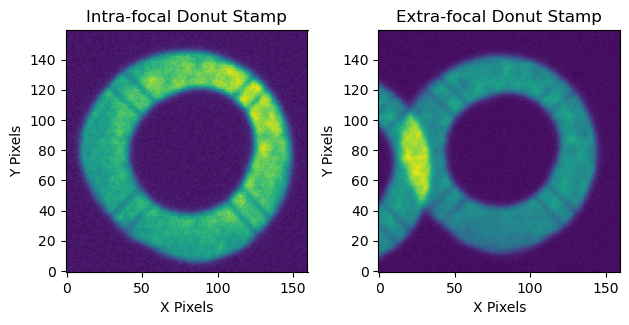

In [14]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(donutStampsIntra[0].stamp_im.image.array, origin='lower')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Intra-focal Donut Stamp')

fig.add_subplot(1,2,2)
plt.imshow(donutStampsExtra[0].stamp_im.image.array, origin='lower')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Extra-focal Donut Stamp')

plt.tight_layout()

**Figure 6**: `DonutStamp` for intra and extra-focal sources.

We can see that the extra-focal donut has an overlapping blend while the intra-focal donut is isolated.

#### Configuring `CalcZernikesTask` for masked deblending

The configuration parameters we want are part of the subtask `EstimateZernikes`.
To look at the donuts used inside the TIE algorithm we will save the history when running the task and only run two iterations of the TIE loop so that the history will load faster.

In [15]:
calcZernConfig = CalcZernikesTaskConfig()
calcZernConfig.estimateZernikes.saveHistory = True
calcZernConfig.estimateZernikes.maxIter = 2

The parameters that turn on masked deblending are set as a dictionary with the `estimateZernikes.maskKwargs` argument.
The default setting has masked deblending turned off.
To show what the donuts look like without deblending we first run with these default settings.

In [16]:
calcZernConfig.estimateZernikes.maskKwargs={'maskBlends': False} # This is the default.

In [17]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [18]:
output_zern_no_deblend = calcZernTask.run(donutStampsExtra=donutStampsExtra, donutStampsIntra=donutStampsIntra)

In [19]:
history_no_deblend = convertMetadataToHistory(calcZernTask.estimateZernikes.metadata)['history']

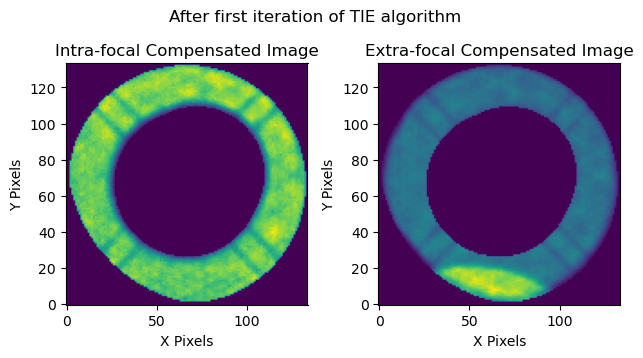

In [20]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(history_no_deblend['pair0'][1]['intraComp'])
plt.title('Intra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,2,2)
plt.imshow(history_no_deblend['pair0'][1]['extraComp'])
plt.title('Extra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

plt.tight_layout()
plt.suptitle('After first iteration of TIE algorithm')
plt.subplots_adjust(top=1.2)


**Figure 7**: Postage stamp images of the intra and extra-focal sources modelled after the first iteration of the Transport of Intensity wavefront estimation algorithm (TIE). In this example the algorithm has not been given any information on the blended source in the extra-focal image and thus has not masked out the overlapping area seen on the bottom of the postage stamp on the right.

Now we will turn on the settings for masked deblending and show donut stamp that has mask included.

New configurations:

* `maskBlends`: Turn on/off masking in donutStamps.

* `dilateBlends`: Number of iterations to run binary dilation to grow mask.

In [21]:
calcZernConfig.estimateZernikes.maskKwargs={'maskBlends': True, 'dilateBlends': 0}

In [22]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [23]:
output_zern_deblended = calcZernTask.run(donutStampsExtra=donutStampsExtra, donutStampsIntra=donutStampsIntra)

In [24]:
history_deblended = convertMetadataToHistory(calcZernTask.estimateZernikes.metadata)['history']

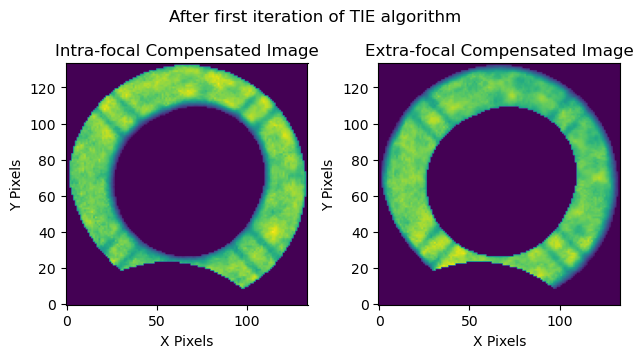

In [25]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(history_deblended['pair0'][1]['intraComp'])
plt.title('Intra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,2,2)
plt.imshow(history_deblended['pair0'][1]['extraComp'])
plt.title('Extra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

plt.tight_layout()
plt.suptitle('After first iteration of TIE algorithm')
plt.subplots_adjust(top=1.2)


**Figure 8**: Postage stamp images of the intra and extra-focal sources modelled after the first iteration of the Transport of Intensity wavefront estimation algorithm (TIE). This time we have passed along information to the TIE algorithm about the blended object so that it can run the Masked Deblending algorithm. Notice that now both images have the area where the blend occurs masked.

Here we see that the mask has been applied in the location of the blend.
Since the TIE algorithm applies the same mask to the intra and extra-focal donuts we see it on both images.

Next we will show the effect of the mask dilation by adding in four iterations of binary dilation.

In [26]:
calcZernConfig.estimateZernikes.maskKwargs={'maskBlends': True, 'dilateBlends': 4}

In [27]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [28]:
output_zern_dilated = calcZernTask.run(donutStampsExtra=donutStampsExtra, donutStampsIntra=donutStampsIntra)

In [29]:
history_dilated = convertMetadataToHistory(calcZernTask.estimateZernikes.metadata)['history']

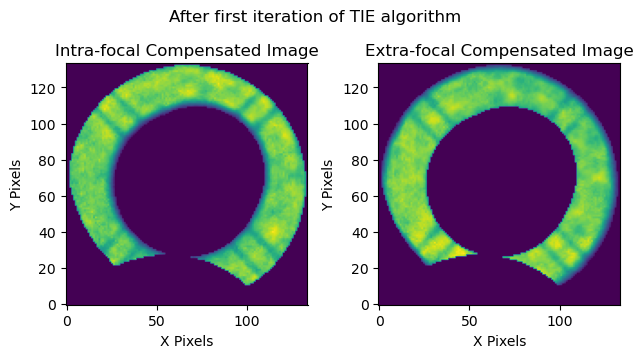

In [30]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(history_dilated['pair0'][1]['intraComp'])
plt.title('Intra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,2,2)
plt.imshow(history_dilated['pair0'][1]['extraComp'])
plt.title('Extra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

plt.tight_layout()
plt.suptitle('After first iteration of TIE algorithm')
plt.subplots_adjust(top=1.2)


**Figure 9**: Postage stamp images of the intra and extra-focal sources modelled after the first iteration of the Transport of Intensity wavefront estimation algorithm (TIE). Once again the TIE includes the masked deblending. But this time we have also dilated the blend mask to make sure to cover any overlapping area that might not fall within an ideal mask due to additional perturbations shifting the blended image.

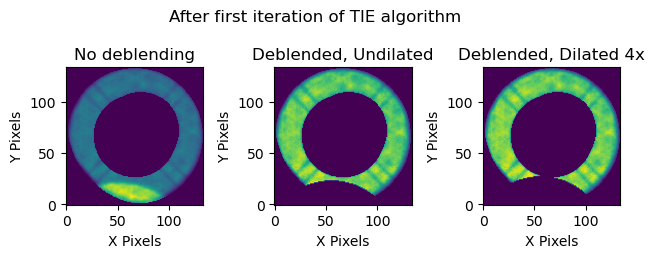

In [31]:
fig = plt.figure()
fig.add_subplot(1,3,1)
plt.imshow(history_no_deblend['pair0'][1]['extraComp'])
plt.title('No deblending')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,3,2)
plt.imshow(history_deblended['pair0'][1]['extraComp'])
plt.title('Deblended, Undilated')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,3,3)
plt.imshow(history_dilated['pair0'][1]['extraComp'])
plt.title('Deblended, Dilated 4x')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

plt.tight_layout()
plt.suptitle('After first iteration of TIE algorithm')
plt.subplots_adjust(top=1.4)


**Figure 10**: Postage stamp images of the extra-focal source modelled after the first iteration of the Transport of Intensity wavefront estimation algorithm (TIE) in each of the above configurations. Left: No Deblending. Center: Masked Deblending with no dilation of the blend mask. Right: Masked Deblending with the blend mask dilated through 4 iterations of the `scipy.ndimage.binary_dilation` function.

### Compare Zernike estimates to OPD

Let's now demonstrate the functionality of the masked deblender by comparing the Zernike estimates from `CalcZernikes` to the OPD "truth" values.

In [32]:
# Load OPD data
with open(os.path.join(notebook_data, 'deblend_extra_110_pixels_no_deblend', 'iter0', 'img', 'opd.zer'), 'r') as f:
    opd = yaml.safe_load(f)

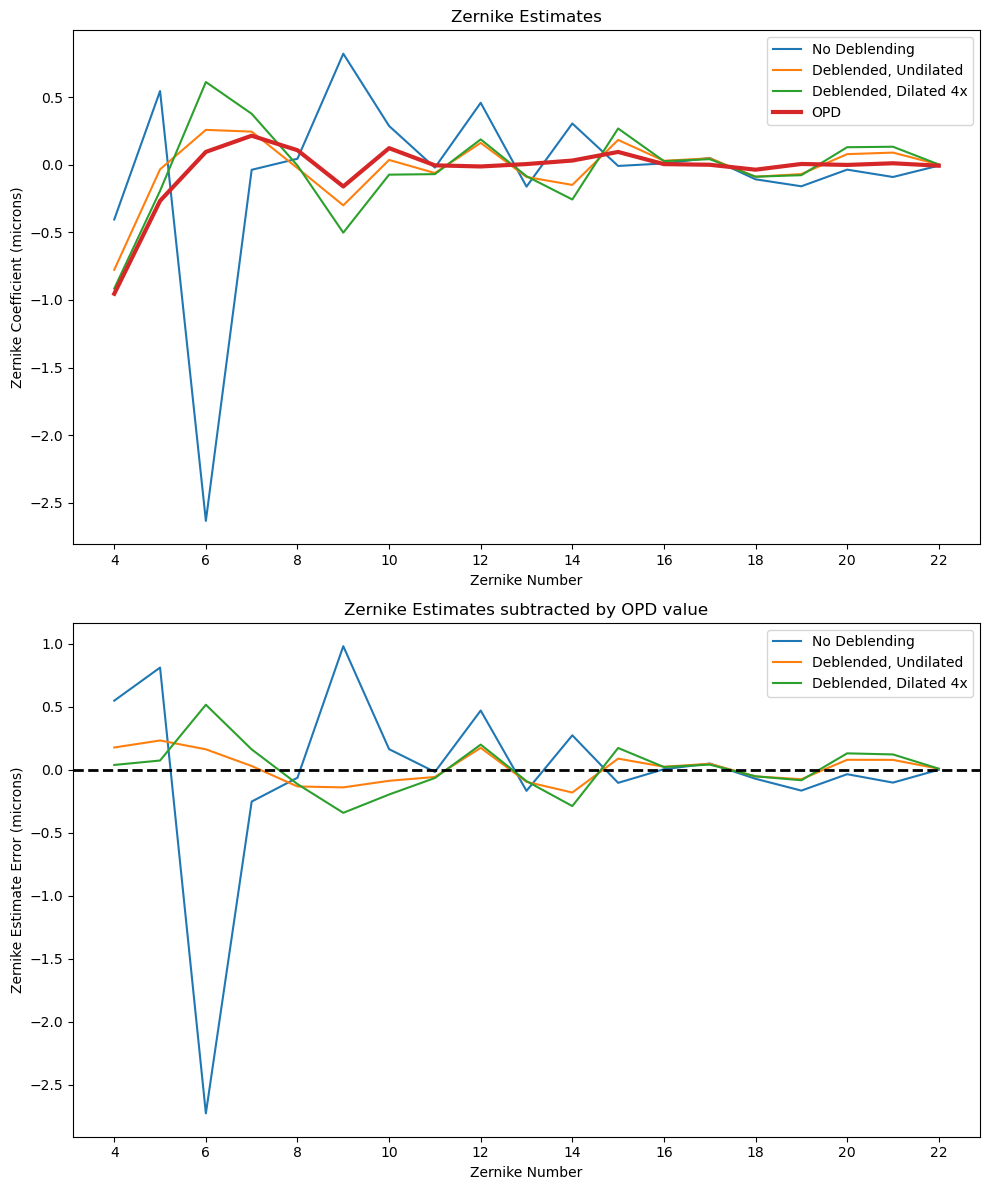

In [68]:
fig = plt.figure(figsize=(10, 12))
fig.add_subplot(2,1,1)
plt.plot(np.arange(4, 23), output_zern_no_deblend.outputZernikesAvg, label='No Deblending')
plt.plot(np.arange(4, 23), output_zern_deblended.outputZernikesAvg, label='Deblended, Undilated')
plt.plot(np.arange(4, 23), output_zern_dilated.outputZernikesAvg, label='Deblended, Dilated 4x')
plt.plot(np.arange(4, 23), np.loadtxt(opd[dataIdExtra['detector']])[:19]/1e3, label='OPD', lw=3)
plt.legend()
plt.title('Zernike Estimates')
plt.xlabel('Zernike Number')
plt.ylabel('Zernike Coefficient (microns)')
plt.xticks(np.arange(4, 23, 2))

fig.add_subplot(2,1,2)
plt.plot(np.arange(4, 23), output_zern_no_deblend.outputZernikesAvg - np.loadtxt(opd[dataIdExtra['detector']])[:19]/1e3, label='No Deblending')
plt.plot(np.arange(4, 23), output_zern_deblended.outputZernikesAvg - np.loadtxt(opd[dataIdExtra['detector']])[:19]/1e3, label='Deblended, Undilated')
plt.plot(np.arange(4, 23), output_zern_dilated.outputZernikesAvg - np.loadtxt(opd[dataIdExtra['detector']])[:19]/1e3, label='Deblended, Dilated 4x')
plt.axhline(0.0, ls='--', c='k', lw=2)
plt.legend()
plt.title('Zernike Estimates subtracted by OPD value')
plt.xlabel('Zernike Number')
plt.ylabel('Zernike Estimate Error (microns)')
plt.xticks(np.arange(4, 23, 2))

plt.tight_layout()

**Figure 11**: Comparison of the various configurations of the Zernike estimates obtained by the TIE algorithm with and without deblending compared to the OPD "truth" values.

The masked deblending Zernike estimates show a large improvement over the unblended Zernike estimates and with max errors in the range of tenths of microns the performance of the deblended Zernike estimates is comparable to the vignetted donut case that inspired this method. After the next section describing some caveats about using this with the full focal plane we show the closed loop results that confirm the deblender is able to produce Zernike estimates that work well enough to allow the AOS closed loop to converge.

### Note on Masks for Science Sensor Images

The results above show the masked deblending applied to the corner wavefront sensors.
When using the corner wavefront sensors the intra and extra-focal sensors image different areas of the sky so that each pair of donut stamps contains images of two different stars.
This is not necessarily true for the AOS pipeline when running in Full Array Mode (FAM).
When running in FAM the same portion of the sky may be imaged with the camera pistoned in and out of focus so that the intra and extra-focal images cover the same set of stars.
This results in the donut catalogs being the same so that the pairs of donut stamps contain the same star.
If that star is blended then both the intra and extra focal images will contain the blended object.
Figure 12 below shows why the blended object appears in both images.

![source_selector_figure 1](notebook_figures/mask_rotate_1.jpg)

**Figure 12**: Demonstration of why two nearby sources in an in-focus image are overlapping in both the intra and extra-focal image.

However, even though there is only one blended star the masks must take out a section of the donut on each side.
This is because in the intra and extra-focal images the star is on the same side of the central star when we view it on the focal plane (see the donut stamps at the beginning of the notebook). 
But because we want to line up the light from the same locations on the mirror we must rotate the extra-focal image by 180 degrees. 
This means the star now ends up on the opposite side of the images used in the TIE calculation so we must mask it on each side of the donut.
Figure 13 below shows why this effect happens by tracing the light paths coming from the mirror.

![source_selector_figure 1](notebook_figures/mask_rotate_2.jpg)

**Figure 13**: Demonstration of why two overlapping defocal sources need to be masked out on both sides of the image when running the TIE on science sensors.

Now we can show this results this produces in the WEP pipeline by running it on simulated ComCam data below. To reproduce these results one can use a `pipetask run` command like the following:

```bash
pipetask run -b deblend_test_repo/ -i refcats,LSSTComCamSim/raw/all,LSSTComCamSim/calib/unbounded 
--instrument lsst.obs.lsst.LsstComCamSim --register-dataset-types -o comcam_90_80_pixels_shift -p science_deblend_pipeline.yaml 
-d "detector IN (0..9) AND instrument='LSSTComCamSim' AND exposure IN (7023062001001, 7023062001002)" -j 4
```

First let's look at the donuts for a source in the intra and extra-focal images for a field where we piston ComCam in and out of focus.

In [34]:
comcam_intra_data_id = {'instrument': 'LSSTComCamSim', 'detector': 3, 'exposure': 7023062001001, 'visit': 7023062001001}
comcam_extra_data_id = {'instrument': 'LSSTComCamSim', 'detector': 3, 'exposure': 7023062001002, 'visit': 7023062001002}

In [35]:
comcam_ds_intra = butler.get('donutStampsIntra', dataId=comcam_extra_data_id, collections='comcam_90_80_pixels_shift')
comcam_ds_extra = butler.get('donutStampsExtra', dataId=comcam_extra_data_id, collections='comcam_90_80_pixels_shift')

Text(0.5, 1.0, 'Extra-focal Image')

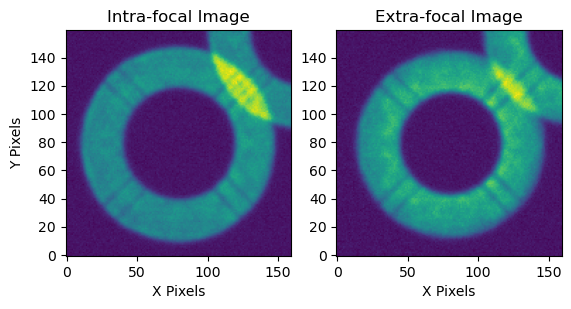

In [69]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(comcam_ds_intra[0].stamp_im.image.array)
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.title('Intra-focal Image')

fig.add_subplot(1,2,2)
plt.imshow(comcam_ds_extra[0].stamp_im.image.array)
plt.xlabel('X Pixels')
plt.title('Extra-focal Image')

**Figure 14**: `DonutStamp` images of the intra and extra-focal simulation of a single blended source using LSST ComCam. Notice here that since we are using ComCam and pistoning in and out on the same field a blended source is blended in both images of an intra and extra-focal pair. This is unlike the wavefront sensors where we pair images of different sources. The difference in the amount of overlap of the blend between the two images is because we are using a perturbed initial optical state that results in a shift in the location of the intra-focal donuts relative to one another. We will see this again in the following sections.

We see in Figure 14 that the overlapping stars are blended in both the intra-focal and extra-focal images as we expected.
Now let's see what the masked deblending algorithm does with this pair of donut images after we incorporate the 180 degree rotation needed to line up the extra-focal image with the intra-focal image as explained in Figure 13.

In [37]:
calcZernConfig.estimateZernikes.maskKwargs={'maskBlends': True, 'dilateBlends': 0}

In [38]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [39]:
output_zern_comcam_deblended = calcZernTask.run(donutStampsExtra=comcam_ds_extra, donutStampsIntra=comcam_ds_intra)

In [40]:
history_comcam = convertMetadataToHistory(calcZernTask.estimateZernikes.metadata)['history']

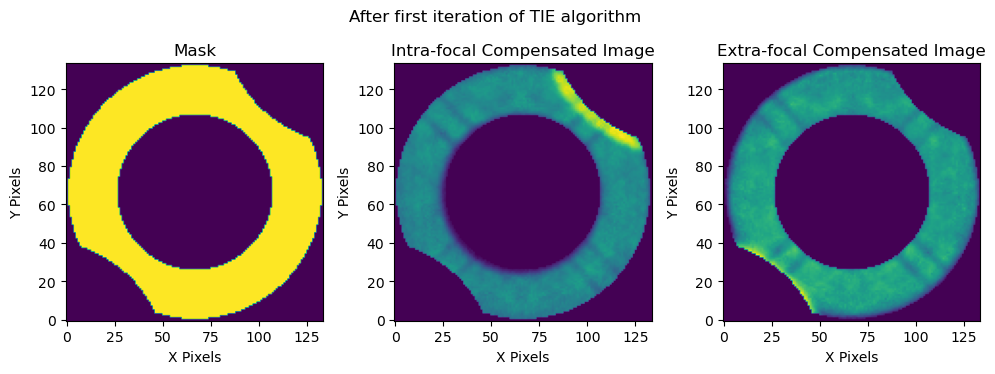

In [41]:
fig = plt.figure(figsize=(10, 4))

fig.add_subplot(1,3,1)
plt.imshow(history_comcam['pair0'][1]['mask'])
plt.title('Mask')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,3,2)
plt.imshow(history_comcam['pair0'][1]['intraComp'])
plt.title('Intra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,3,3)
plt.imshow(history_comcam['pair0'][1]['extraComp'])
plt.title('Extra-focal Compensated Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

plt.tight_layout()
plt.suptitle('After first iteration of TIE algorithm')
plt.subplots_adjust(top=1.0)


**Figure 15**: `DonutStamp` images of the mask used by the TIE algorithm that needs to take into account the blend on both sides of the donut when running the TIE on the intra and extra-focal images. Left: Binary Mask, Center: Intra-focal image with binary mask applied for the TIE, Right: Extra-focal image with binary mask applied for the TIE.

We see that because the blended source covers the central source on the opposite side of the donut in each of the defocal images that we need to mask both sides of the donut when running the TIE algorithm. This means that compared to the wavefront sensors we are losing twice as much area and as a result the masked deblending performs much more poorly for an overlapping donut.

In [42]:
# Load OPD data
with open(os.path.join(notebook_data, 'comcam_shift_90_80_pixels', 'opd.zer'), 'r') as f:
    opd_comcam = yaml.safe_load(f)

# Load Data without deblending
output_zern_comcam_base = butler.get('zernikeEstimateAvg', dataId=comcam_extra_data_id, collections='comcam_90_80_pixels_shift')

In [43]:
calcZernConfig.estimateZernikes.maskKwargs={'maskBlends': True, 'dilateBlends': 4}
calcZernTask = CalcZernikesTask(config=calcZernConfig)
output_zern_comcam_dilated = calcZernTask.run(donutStampsExtra=comcam_ds_extra, donutStampsIntra=comcam_ds_intra)

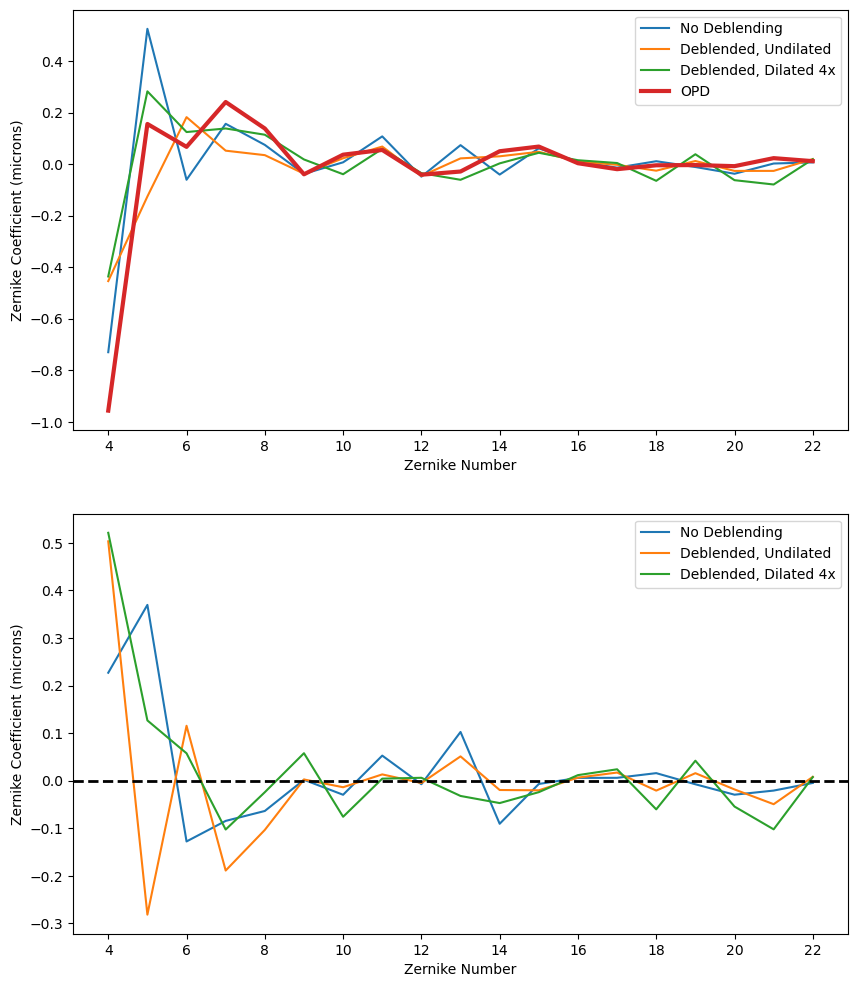

In [71]:
fig = plt.figure(figsize=(10, 12))
fig.add_subplot(2,1,1)
plt.plot(np.arange(4, 23), output_zern_comcam_base, label='No Deblending')
plt.plot(np.arange(4, 23), output_zern_comcam_deblended.outputZernikesAvg, label='Deblended, Undilated')
plt.plot(np.arange(4, 23), output_zern_comcam_dilated.outputZernikesAvg, label='Deblended, Dilated 4x')
plt.plot(np.arange(4, 23), np.loadtxt(opd_comcam[3])[:-6]/1e3, label='OPD', lw=3)
plt.legend()
plt.xlabel('Zernike Number')
plt.ylabel('Zernike Coefficient (microns)')
plt.xticks(np.arange(4, 23, 2))

fig.add_subplot(2,1,2)
plt.plot(np.arange(4, 23), output_zern_comcam_base-np.loadtxt(opd_comcam[3])[:-6]/1e3, label='No Deblending')
plt.plot(np.arange(4, 23), output_zern_comcam_deblended.outputZernikesAvg-np.loadtxt(opd_comcam[3])[:-6]/1e3, label='Deblended, Undilated')
plt.plot(np.arange(4, 23), output_zern_comcam_dilated.outputZernikesAvg-np.loadtxt(opd_comcam[3])[:-6]/1e3, label='Deblended, Dilated 4x')
plt.axhline(0.0, ls='--', c='k', lw=2)
plt.xlabel('Zernike Number')
plt.ylabel('Zernike Coefficient (microns)')
plt.xticks(np.arange(4, 23, 2))

plt.legend()

**Figure 16**: TIE performance on ComCam with and without masked deblending. The masked deblending is not as helpful due to the greater area that needs to be masked compared to the wavefront sensor mode.

## Closed Loop Testing

In this section we show the results of the masked deblending in the AOS closed loop. We ran the closed loop on a variety of different separations between the two donuts in order to find the limit at which the masked deblending starts to break down. We also ran it with a series of different dilations to try and guide our settings when choosing the amount of dilation for masked deblending. We ran all sets of simulations twice, once where there a was a single blend on the extra-focal donut and the intra-focal donut was isolated and then the reverse case.
The data was simulated with the perturbations found in [lsstCamLargePert.yaml](https://github.com/lsst-ts/ts_imsim/blob/develop/policy/config/input/telescope/lsstCamLargePert.yaml) in the `ts_imsim` policy directory. Below we show the results comparing the final converged FWHM values obtained in the closed loop.

In [45]:
results_base_dir = '/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/donut_deblending/closed_loop_results'

In [46]:
results_output_dirs = os.listdir(results_base_dir)

In [47]:
results_dir_dict = {}
results_dir_dict['extra'] = {}
results_dir_dict['intra'] = {}
for entry in results_output_dirs:
    entry_names = entry.split('_')
    defocal_type = entry_names[1]
    separation = entry_names[2]
    deblend_type = entry_names[-2] + '_' + entry_names[-1]
    if separation not in results_dir_dict[defocal_type]:
        results_dir_dict[defocal_type][separation] = {}

    pssn_all = []
    fwhm_all = []
    for i in range(5):
        try:
            pssn_file = np.genfromtxt(os.path.join(results_base_dir, entry, f'iter{i}', 'img', 'PSSN.txt'))
            pssn_all.append(pssn_file[0][-1])
            fwhm_all.append(pssn_file[1][-1])
        except FileNotFoundError:
            continue
    pssn_all = np.array(pssn_all)
    fwhm_all = np.array(fwhm_all)
    
    results_dir_dict[defocal_type][separation][deblend_type] = {'pssn': pssn_all, 'fwhm': fwhm_all}

Text(0.5, 1.0, 'Intra-focal Donuts')

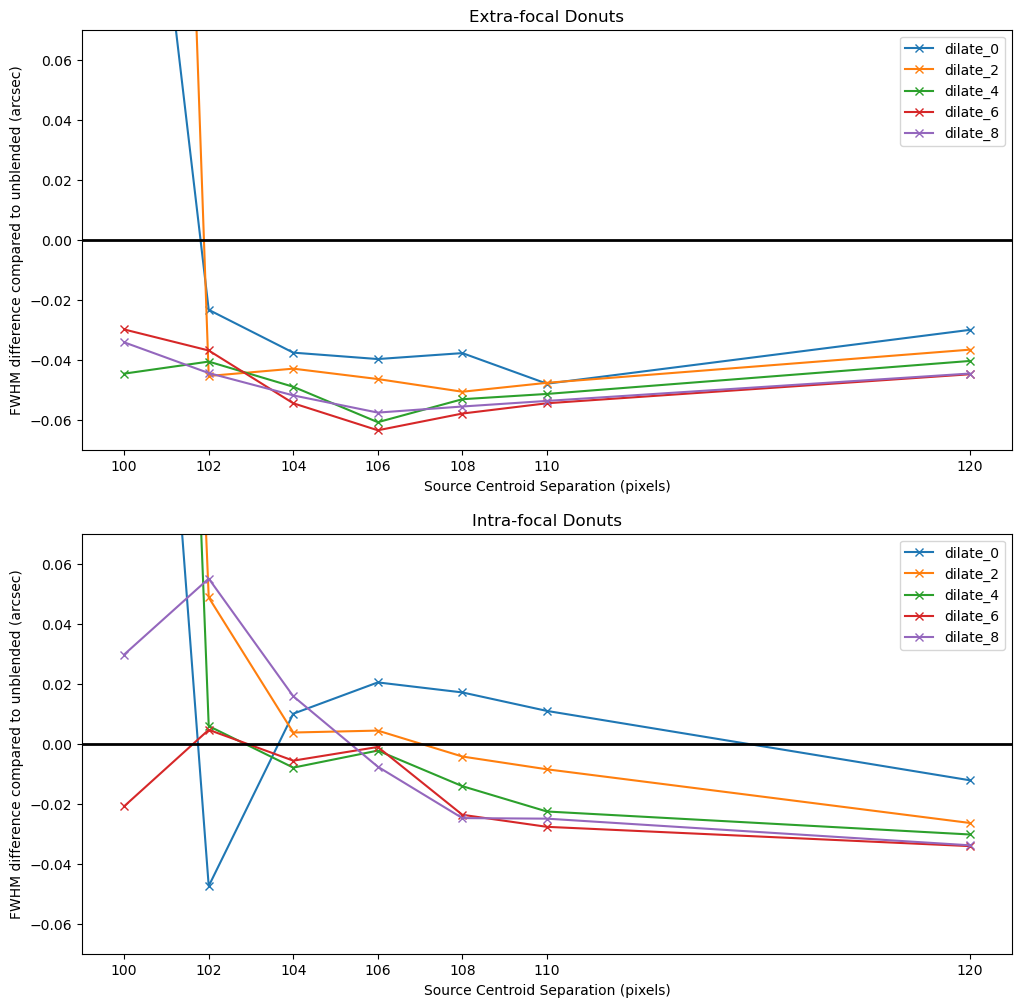

In [48]:
all_keys = ['no_deblend', 'dilate_0', 'dilate_2', 'dilate_4', 'dilate_6', 'dilate_8']
sep_keys = ['120', '110', '108', '106', '104', '102', '100']
fig = plt.figure(figsize=(12, 12))
two_d_extra = []
fig.add_subplot(2,1,1)

defocal_type = 'extra'

no_deblend_all_extra = []
for sep in sep_keys:
    no_deblend_all_extra.append(results_dir_dict[defocal_type][sep]['no_deblend']['fwhm'][-1])

for deblend_type in all_keys[1:]:
    final_conv = []
    for sep in sep_keys:
        if results_dir_dict[defocal_type][sep][deblend_type]['fwhm'][-1] == 0.0:
            final_conv.append(1.0)
        else:
            final_conv.append(results_dir_dict[defocal_type][sep][deblend_type]['fwhm'][-1])
    two_d_extra.append(final_conv)
    plt.plot(np.array(sep_keys, dtype=int), np.array(final_conv) - np.array(no_deblend_all_extra), '-x', label=deblend_type)
# plt.gca().invert_xaxis()
plt.axhline(0.0, lw=2, c='k')
plt.legend()
plt.ylim(-0.07, 0.07)
plt.xticks(np.array(sep_keys, dtype=int))
plt.xlabel('Source Centroid Separation (pixels)')
plt.ylabel('FWHM difference compared to unblended (arcsec)')
plt.title('Extra-focal Donuts')

fig.add_subplot(2,1,2)

defocal_type = 'intra'
two_d_intra = []
no_deblend_all_intra = []
for sep in sep_keys:
    no_deblend_all_intra.append(results_dir_dict[defocal_type][sep]['no_deblend']['fwhm'][-1])

for deblend_type in all_keys[1:]:
    final_conv = []
    for sep in sep_keys:
        if results_dir_dict[defocal_type][sep][deblend_type]['fwhm'][-1] == 0.0:
            final_conv.append(1.0)
        else:
            final_conv.append(results_dir_dict[defocal_type][sep][deblend_type]['fwhm'][-1])
    two_d_intra.append(final_conv)
    plt.plot(np.array(sep_keys, dtype=int), np.array(final_conv) - np.array(no_deblend_all_intra), '-x', label=deblend_type)
# plt.gca().invert_xaxis()
plt.axhline(0.0, lw=2, c='k')
plt.legend()
plt.ylim(-0.07, 0.07)
plt.xticks(np.array(sep_keys, dtype=int))
plt.xlabel('Source Centroid Separation (pixels)')
plt.ylabel('FWHM difference compared to unblended (arcsec)')
plt.title('Intra-focal Donuts')

**Figure 17**: AOS closed loop results after 5 iterations comparing TIE performance with masked deblending to a no deblending baseline as a function of the separation between the centroid of two sources in pixels.

In the plots above we show how the final converged FWHM effective value in the closed loop with masked deblending compares to the closed loop without deblending. Positive values are where the masked deblending performed worse than no deblending at all while values below 0 (shown with the black line) show where the masked deblending improved the closed loop result over no deblending. Looking at the two plots we see that the masked deblending performed much better in the extra-focal images. The results suggest that we can deblend sources with a small amount of dilation down to 100 pixel separations if we need to but a safer value might be around 104 pixels between sources. However, when we look at the intra-focal sources we see that the results are not as good of an improvement. At 120 pixels all sets of dilation improve over no deblending but at 110 pixels some dilation is necessary and the improvements over no deblending are not as great as in the extra-focal case. In fact, it seems that with some dilation (2-8 iterations) we are only reliably improving over no deblending down to 108 pixels between sources. Let's examine the donut stamps to understand why there might be some difference between the two sets of results.

In [49]:
dataIdExtra_intra_110_sep = {
    'instrument': 'LSSTCam', 
    'detector': 191, 
    'exposure': 7023062002000,
    'visit': 7023062002000
}
dataIdIntra_intra_110_sep = {
    'instrument': 'LSSTCam', 
    'detector': 192, 
    'exposure': 7023062002000,
    'visit': 7023062002000
}

In [50]:
donutStampsExtra_intra_110_sep = butler.get('donutStampsExtra', dataId=dataIdExtra_intra_110_sep, collections='cwfs_intrafocal_110_pixels_separation')

In [51]:
donutStampsIntra_intra_110_sep = butler.get('donutStampsIntra', dataId=dataIdExtra_intra_110_sep, collections='cwfs_intrafocal_110_pixels_separation')

Text(0, 0.5, 'Y Pixels')

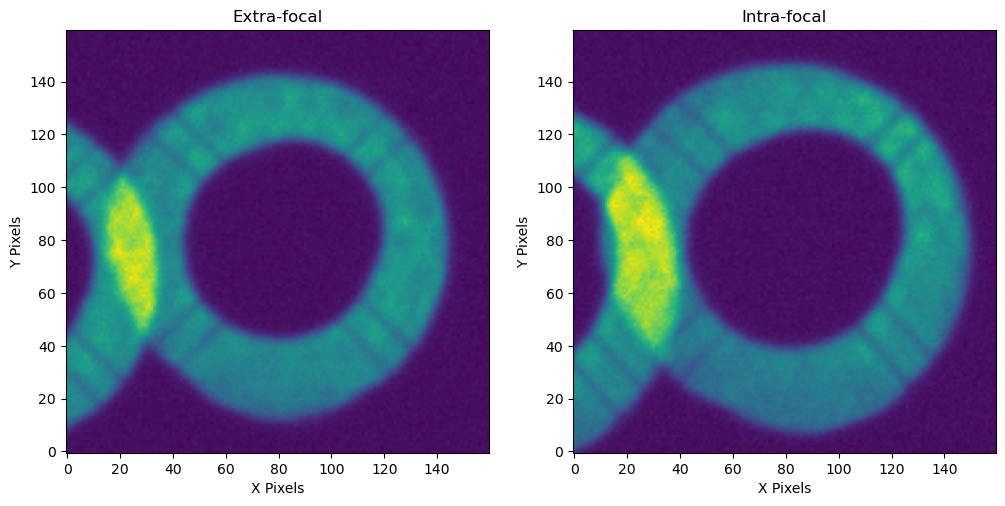

In [52]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1,2,1)
plt.imshow(donutStampsExtra[0].stamp_im.image.array)
plt.title('Extra-focal')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
fig.add_subplot(1,2,2)
plt.imshow(donutStampsIntra_intra_110_sep[0].stamp_im.image.array)
plt.title('Intra-focal')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

**Figure 18**: `DonutStamp` images showing the shift in the location of the blended source between the extra and intra-focal images that comes from the optical system perturbations.

The intra-focal and extra-focal images were created with the same separations between the donuts and the same set of perturbations but the donuts cover different amounts of the central donut in the two cases. What is happening is that this particular set of perturbations shifts the donuts differently in the two different defocal distances. This same set of perturbations was also used to set up the initial optical state for the ComCam simulation in the previous section where we noted this same effect as well when shifting the camera from one side of focus to the other. Even with these differences on each side of focus the results of this closed loop study show that a small amount of dilation can account for these shifts. Below we show how dilating the donut with 4 iterations of binary dilation improves the masking.

In [53]:
calcZernConfig.estimateZernikes.maskKwargs={'maskBlends': True, 'dilateBlends': 0}

In [54]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [55]:
output_zern_no_dilation_intra_110_sep = calcZernTask.run(
    donutStampsExtra=donutStampsExtra_intra_110_sep, 
    donutStampsIntra=donutStampsIntra_intra_110_sep
)

In [56]:
history_no_dilation = convertMetadataToHistory(calcZernTask.estimateZernikes.metadata)['history']

In [57]:
calcZernConfig.estimateZernikes.maskKwargs={'maskBlends': True, 'dilateBlends': 4}

In [58]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [59]:
output_zern_dilated_4_intra_110_sep = calcZernTask.run(
    donutStampsExtra=donutStampsExtra_intra_110_sep, 
    donutStampsIntra=donutStampsIntra_intra_110_sep
)

In [60]:
history_dilated_4 = convertMetadataToHistory(calcZernTask.estimateZernikes.metadata)['history']

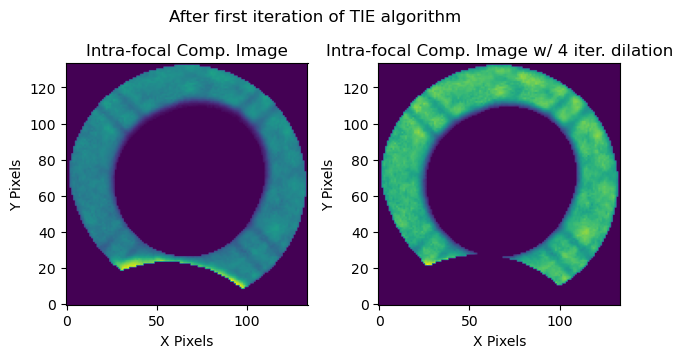

In [61]:
fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(history_no_dilation['pair0'][1]['intraComp'])
plt.title('Intra-focal Comp. Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,2,2)
plt.imshow(history_dilated_4['pair0'][1]['intraComp'])
plt.title('Intra-focal Comp. Image w/ 4 iter. dilation')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

plt.tight_layout()
plt.suptitle('After first iteration of TIE algorithm')
plt.subplots_adjust(top=1.2)


**Figure 19**: Comparison of the effectiveness of binary dilation when there are large shifts in the location of the overlapping source due to optical system perturbations.

To account for shifts due to perturbations we should always use around 4 iterations of binary dilation when running the deblender. However, active work is being done to implement an automatic dilation algorithm so that the user will not have to worry about choosing the dilation in the near future.

For a new threshold on the validity of the masked deblender, we can use the results from the closed loop conservatively to set this at around 110 pixels. Using the masks for the 110 pixel separation examples in the notebook we can calculate the area of the donut that can be blended and still be useful for wavefront estimation.

In [62]:
# Use masks to calculate percentage of donut area covered at 110 pixel separation
(np.sum(history_no_deblend['pair0'][1]['mask']) - np.sum(history_deblended['pair0'][1]['mask']))/np.sum(history_no_deblend['pair0'][1]['mask'])

0.12055285385206041

## Summary

Based upon these studies it seems that the masked deblender successfully improves results in the closed loop consistently down to separations of ~108 pixels and should use approximately 4 iterations of binary dilation to account for shifts in the donuts on either side of focus due to perturbations in the optical system. To be conservative we will set a new default distance of the minimum distance between two blended objects (the `minBlendedSeparation` parameter in the source selector) at 110 pixels which means we can use WEP on donuts with up to ~12% of their area blended.